In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
fileName = 'C:/Users/akaba/Downloads/usa_00009.csv'
file = pd.read_csv(fileName)
dfCDI = pd.DataFrame(file)

C:\Users\akaba\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
dfCDI.shape

(6086626, 38)

In [4]:
dfCDI = dfCDI[dfCDI['AGE']>=21]
dfCDI.shape

(4199977, 38)

In [5]:
dfHomeOwn=dfCDI[dfCDI['OWNERSHP']==1]
dfHomeOwn.RENTGRS.describe()

count    2580898.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: RENTGRS, dtype: float64

In [6]:
dfCDI = dfCDI[dfCDI['OWNERSHP']!=0]
dfCDI.shape

(4093964, 38)

In [7]:
dfCDI['affrentdec'] = dfCDI['RENTGRS']*12/dfCDI['HHINCOME']

In [8]:
def housingFunc(own, affrentdec):
    if own==1:
        housingCat=2
    elif own==2 and affrentdec<.3:
        housingCat=1
    else:
        housingCat=0
    return housingCat

In [9]:
dfCDI['HousingCat'] = dfCDI.apply(lambda x: housingFunc(x['OWNERSHP'], x['affrentdec']), axis=1)
dfCDI['HousingCat'].value_counts()

2    2580898
1     896373
0     616693
Name: HousingCat, dtype: int64

In [10]:
dfCDI['EDUCbin'] = [1 if x >=8 else 0 for x in dfCDI['EDUC']]
dfCDI['EDUCbin'].value_counts()

0    2687862
1    1406102
Name: EDUCbin, dtype: int64

In [11]:
dfCDI['TRANTIME'].value_counts()

0      1938226
15      328333
30      311230
20      310880
10      273784
        ...   
117          2
114          2
126          1
119          1
118          1
Name: TRANTIME, Length: 132, dtype: int64

## Split by year

In [12]:
dfCDI['YEAR'].value_counts()

2010    1219545
2000    1119919
1990     980231
1980     774269
Name: YEAR, dtype: int64

In [13]:
df10=dfCDI[dfCDI['YEAR']==2010]
df00=dfCDI[dfCDI['YEAR']==2000]
df90=dfCDI[dfCDI['YEAR']==1990]
df80=dfCDI[dfCDI['YEAR']==1980]

In [14]:
print(dfCDI.columns.get_loc("HousingCat"))
print(dfCDI.columns.get_loc("EDUCbin"))
print(dfCDI.columns.get_loc("TRANTIME"))
print(dfCDI.columns.get_loc("HHWT"))
print(dfCDI.columns.get_loc("HHINCOME"))
print(dfCDI.columns.get_loc("RACE"))
print(dfCDI.columns.get_loc("AGE"))
print(dfCDI.columns.get_loc("HISPAN"))

39
40
37
5
19
24
23
26


In [15]:
x10 = df10.iloc[:, [39,40,37,5,19,24,23,26]]
x00 = df00.iloc[:, [39,40,37,5,19,24,23,26]]
x90 = df90.iloc[:, [39,40,37,5,19,24,23,26]]
x80 = df80.iloc[:, [39,40,37,5,19,24,23,26]]


In [16]:
combined = [x10, x00,x90,x80]
scaler=StandardScaler()
scalerNum = scaler.fit(x10)
scalerNum1 = scaler.fit(x00)
scalerNum2 = scaler.fit(x90)
scalerNum3 = scaler.fit(x80)

xstd10 = scalerNum.transform(x10)
xstd00 = scalerNum1.transform(x00)
xstd90 = scalerNum2.transform(x90)
xstd80 = scalerNum3.transform(x80)



In [17]:
dfX10 = pd.DataFrame(xstd10, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX00 = pd.DataFrame(xstd00, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX90 = pd.DataFrame(xstd90, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX80 = pd.DataFrame(xstd80, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])

In [18]:
dfX10.describe()

,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
count,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06
mean,2.698073e-02,1.184473e-01,6.086986e-01,-4.556158e-01,4.254888e+00,1.018671e+00,2.701595e-01,2.251015e-01
std,1.047217e+00,1.032853e+00,1.544790e+00,1.247884e+01,5.497525e+00,2.116758e+00,1.005013e+00,1.196506e+00
min,-2.055204e+00,-7.154482e-01,-4.876382e-01,-1.900000e+01,-3.886748e+00,-3.232548e-01,-1.352563e+00,-3.346936e-01
25%,-6.702941e-01,-7.154482e-01,-4.876382e-01,-8.000000e+00,8.792385e-01,-3.232548e-01,-5.277294e-01,-3.346936e-01
50%,7.146155e-01,-7.154482e-01,2.215917e-01,-4.000000e+00,2.892476e+00,-3.232548e-01,1.792709e-01,-3.346936e-01
75%,7.146155e-01,1.397725e+00,1.285437e+00,3.000000e+00,5.802513e+00,2.312807e+00,9.451878e-01,9.831339e-01
max,7.146155e-01,1.397725e+00,1.213665e+01,1.970000e+02,1.228776e+02,6.706243e+00,2.889438e+00,4.936616e+00


In [19]:
# #7 clusters for now
# for i in range(3,10):
#     km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#     cluster_labels = km.fit_predict(dfX.iloc[:,0:8])
#     silhouette_avg = silhouette_score(dfX.iloc[:,0:8], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
#     print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

In [20]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(dfX10.iloc[:,0:3])
X10fin = scaler.inverse_transform(dfX10)
dfX10fin = pd.DataFrame(X10fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX10fin['labels'] = kmeans.labels_
cluster_sum10 = dfX10fin.groupby(by = 'labels').mean()
cluster_sum10.head(7)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,1.584885,0.000000,39.112249,20.772176,91776.175001,2.890375,42.510348,0.684975
1,2.000000,0.000000,4.534854,18.038779,83888.948144,2.393543,54.551295,0.450084
2,1.835803,1.000000,35.199632,18.506852,152234.151763,2.499125,44.800647,0.225673
3,0.551149,1.000000,10.080361,21.390583,76692.550884,2.554073,41.746564,0.256409
4,0.416891,0.000000,7.009557,22.995821,46030.139842,2.934847,44.125558,0.668390
5,2.000000,1.000000,4.122929,17.327627,134809.310267,2.074267,53.731095,0.167835
6,1.581883,0.437511,104.737919,20.186740,110057.834072,2.605566,43.797589,0.495834


<AxesSubplot:>

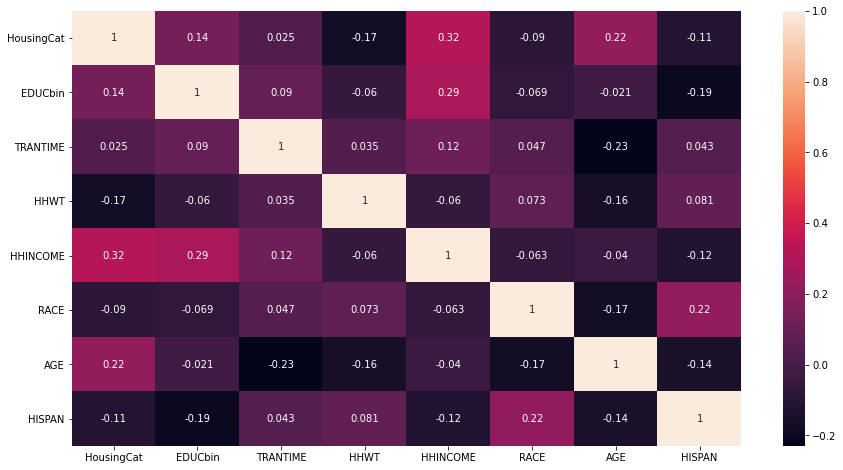

In [21]:
Xcorr10=dfX10fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr10.corr(), annot = True)


In [22]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(dfX00.iloc[:,0:3])
X00fin = scaler.inverse_transform(dfX00)
dfX00fin = pd.DataFrame(X00fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX00fin['labels'] = kmeans.labels_
cluster_sum00 = dfX00fin.groupby(by = 'labels').mean()
cluster_sum00.head(7)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,0.488981,0.000000,3.243122,20.253031,45010.489918,3.397404,42.581117,0.735861
1,1.279854,0.000000,28.894549,20.114916,74600.923102,3.239739,38.521377,0.669677
2,0.669508,1.000000,12.559914,21.118879,68628.939074,2.578234,39.303514,0.232865
3,1.499471,0.312467,154.488186,20.081732,84589.202698,2.811673,41.796685,0.547346
4,2.000000,0.000000,4.535311,19.406568,69768.234665,2.598878,52.322061,0.449786
5,1.679307,0.529246,57.671369,20.202498,98874.888457,2.604589,41.355843,0.380036
6,2.000000,1.000000,11.179552,19.692524,115916.671350,2.077103,49.210272,0.150946


<AxesSubplot:>

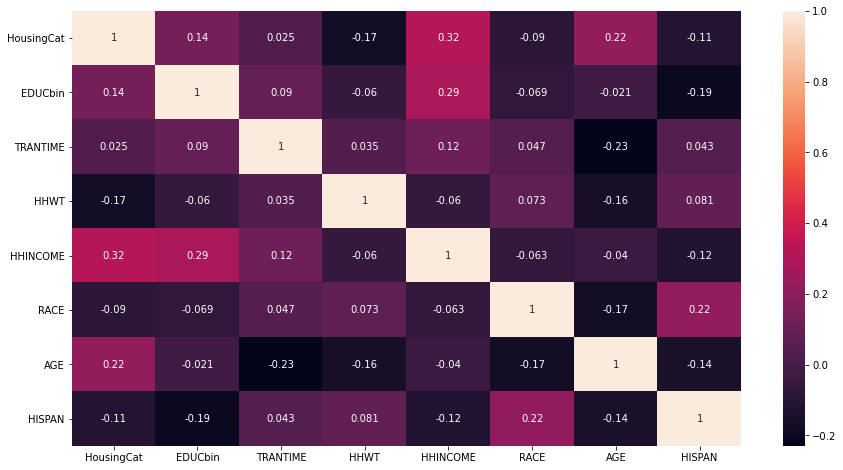

In [23]:
Xcorr00=dfX10fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr00.corr(), annot = True)


In [24]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(dfX90.iloc[:,0:3])
X90fin = scaler.inverse_transform(dfX90)
dfX90fin = pd.DataFrame(X90fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX90fin['labels'] = kmeans.labels_
cluster_sum90 = dfX90fin.groupby(by = 'labels').mean()
cluster_sum90.head(7)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,0.512050,0.00000,7.537002,21.532872,29141.784831,2.681319,39.891515,0.554522
1,1.691727,0.00000,31.095980,20.021389,55783.682905,2.360296,39.346529,0.447218
2,2.000000,0.00000,3.393288,19.393938,47746.327449,1.901961,52.859562,0.277679
3,2.000000,1.00000,5.586190,19.348924,73200.134748,1.614445,48.039040,0.118242
4,1.852587,1.00000,33.937811,19.812491,77753.019532,1.892396,40.597511,0.151948
5,1.437834,0.25538,72.917562,20.774276,54957.426223,2.216632,38.668361,0.438323
6,0.610665,1.00000,11.402876,22.210921,41188.111776,1.969215,37.481931,0.219935


<AxesSubplot:>

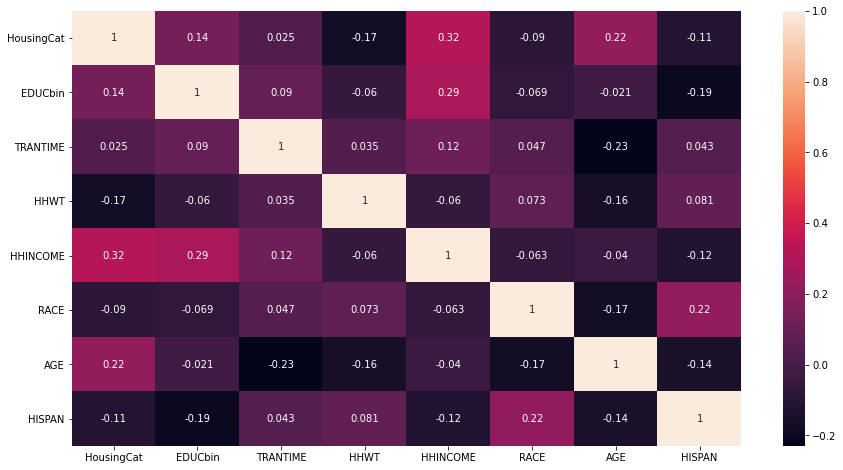

In [25]:
Xcorr90=dfX10fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr90.corr(), annot = True)


In [26]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(dfX80.iloc[:,0:3])
X80fin = scaler.inverse_transform(dfX80)
dfX80fin = pd.DataFrame(X80fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX80fin['labels'] = kmeans.labels_
cluster_sum80 = dfX80fin.groupby(by = 'labels').mean()
cluster_sum80.head(7)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,1.000000,0.00000,2.938729,20.0,20355.172934,1.395699,39.792306,0.423446
1,2.000000,1.00000,5.061197,20.0,34217.164684,1.377073,43.567464,0.123767
2,2.000000,0.00000,1.425863,20.0,24791.428704,1.288055,50.154878,0.234940
3,1.602791,0.69778,57.026904,20.0,30967.390142,1.446103,39.170355,0.227786
4,0.000000,0.00000,3.172732,20.0,7426.315479,1.436059,42.870936,0.378124
5,0.663703,1.00000,5.439289,20.0,19614.508259,1.465298,35.501630,0.176931
6,1.714300,0.00000,30.268659,20.0,27482.051341,1.389613,40.457716,0.337200


<AxesSubplot:>

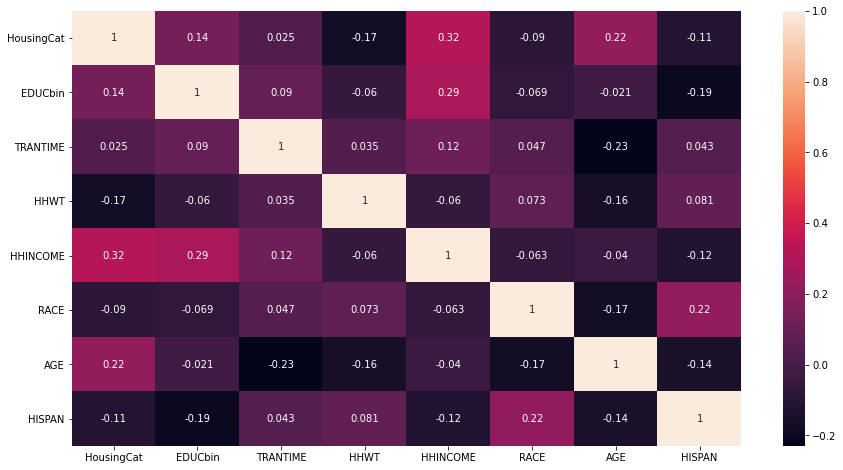

In [27]:
Xcorr80=dfX10fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr80.corr(), annot = True)
